In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, AgglomerativeClustering, OPTICS, DBSCAN, cluster_optics_dbscan
from sklearn_extra.cluster import KMedoids
import random
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean
from sklearn.base import clone
import yfinance as yf
from utils.utils import Portfolio
from utils.helpers import pooled_within_ssd, gen_realizations, gap_statistic, cluster_range, plot_internal, plot_internal_zoom_range, generate_date_combinations
from utils.clusters import kmeans_cluster, kmedoids_cluster, agglomerative_cluster
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers = 6)
from tqdm import tqdm

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


### Load Data from YF for S&P500 and save it

In [3]:
sp500 = Portfolio('2013-01-01', '2024-01-01')
dji = Portfolio('2012-01-01','2024-01-01', file = 'data/dji.csv')
gspc = Portfolio('2012-01-01','2024-01-01', file = 'data/gspc.csv')

### KMeans (3:1)

In [4]:
kmeans3s = pd.read_csv('data/kmedoids_scaled_3-1.csv')
kmeans3s['rank'] = kmeans3s.groupby('Sell')['sharpe'].rank(method='max', ascending=False)
kmeans3s = kmeans3s[kmeans3s['rank'] == 1].drop(['rank'], axis = 1)

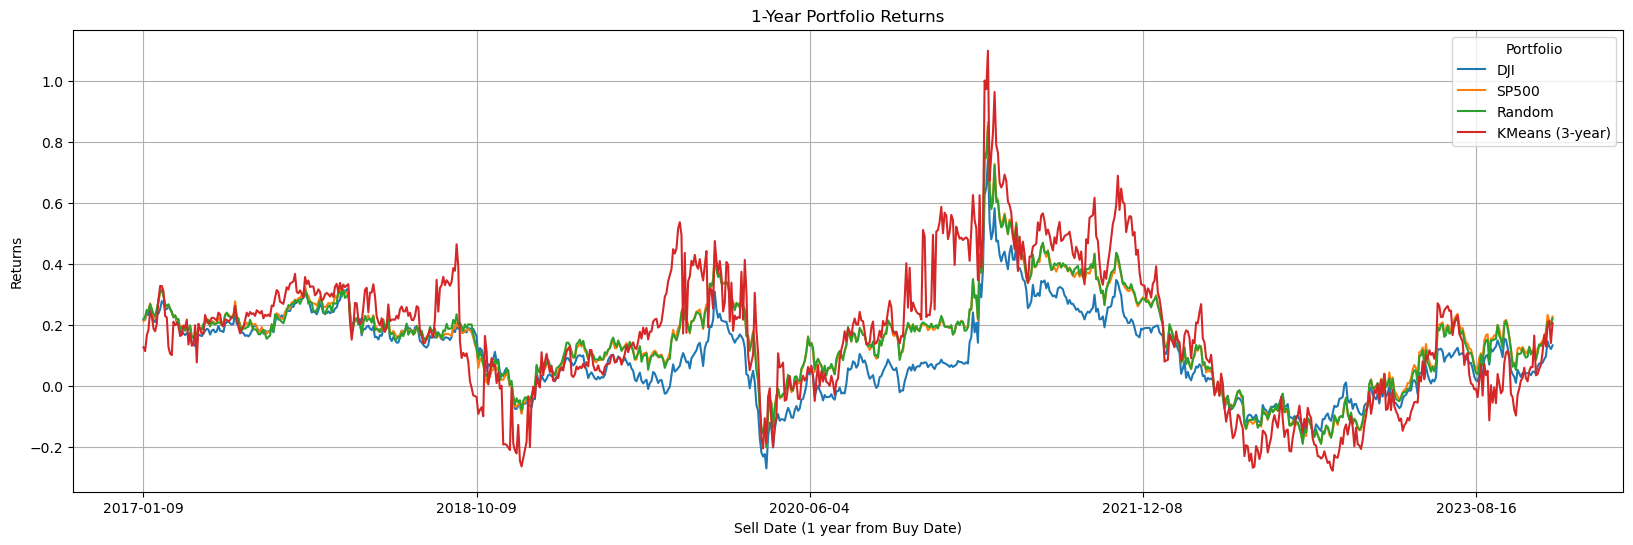

In [5]:
kmeans3s_returns = kmeans3s[['Sell', 'DJI_Return', 'SP500_Return', 'Random_Return', 'return']]
kmeans3s_returns.columns = ['Sell Date', 'DJI', 'SP500', 'Random', 'KMeans (3-year)']
kmeans3s_returns = kmeans3s_returns.set_index('Sell Date')
ig, ax = plt.subplots(figsize=(20, 6))

kmeans3s_returns.plot(ax=ax)

ax.set_title('1-Year Portfolio Returns')
ax.set_xlabel('Sell Date (1 year from Buy Date)')
ax.set_ylabel('Returns')
ax.legend(title='Portfolio')
ax.grid(True)

# Show the plot
plt.show()

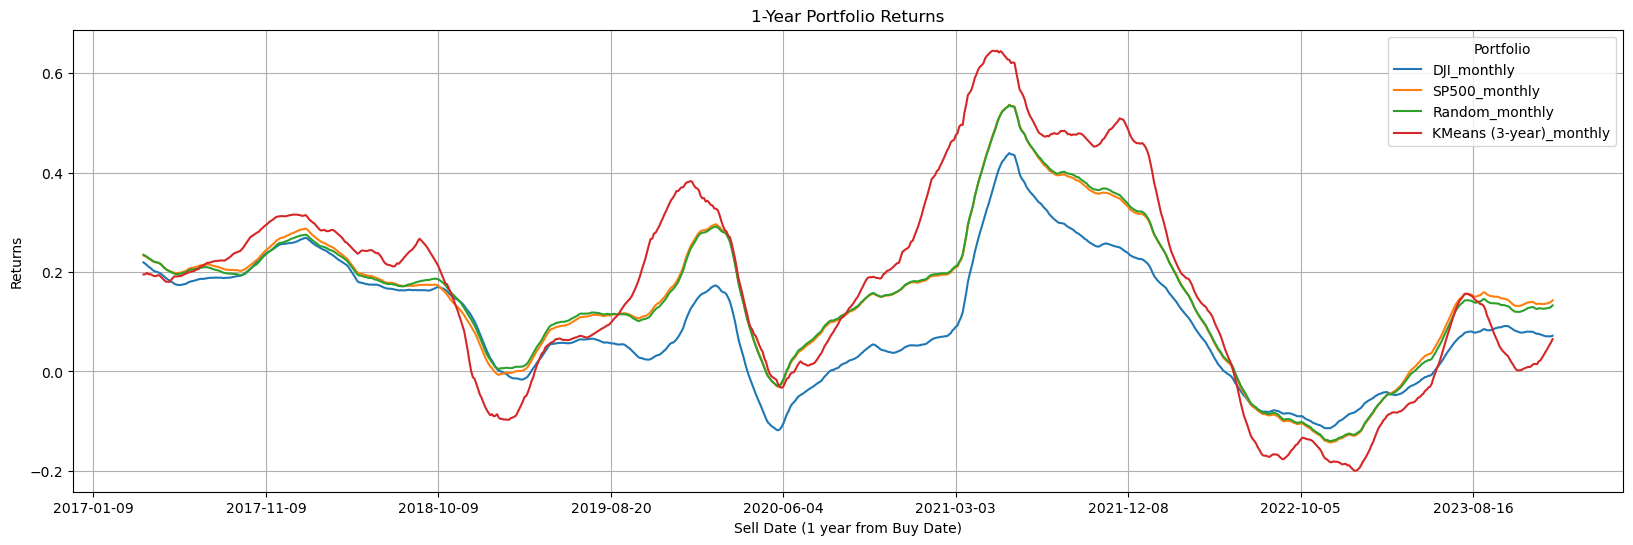

In [6]:
cols = ['DJI', 'SP500', 'Random', 'KMeans (3-year)']
cols_monthly = []
for k in cols:
    colname = f"{k}_monthly"
    kmeans3s_returns[colname] = kmeans3s_returns[k].rolling(window=30).mean()
    cols_monthly.append(colname)

fig, ax = plt.subplots(figsize=(20, 6))


kmeans3s_returns[cols_monthly].plot(ax=ax)

ax.set_title('1-Year Portfolio Returns')
ax.set_xlabel('Sell Date (1 year from Buy Date)')
ax.set_ylabel('Returns')
ax.legend(title='Portfolio')
ax.grid(True)

# Show the plot
plt.show()

In [ ]:
cols = ['DJI', 'SP500', 'Random', 'KMeans (3-year)']
cols_monthly = []
for k in cols:
    colname = f"{k}_monthly"
    kmeans3s_returns[colname] = kmeans3s_returns[k].rolling(window=30).mean()
    cols_monthly.append(colname)

fig, ax = plt.subplots(figsize=(20, 6))


kmeans3s_returns[cols_monthly].plot(ax=ax)

ax.set_title('1-Year Portfolio Returns')
ax.set_xlabel('Sell Date (1 year from Buy Date)')
ax.set_ylabel('Returns')
ax.legend(title='Portfolio')
ax.grid(True)

# Show the plot
plt.show()

,DJI,SP500,Random,KMeans (3-year)
Sell Date,,,,
2017-12-27,0.242128,0.270219,0.271987,0.291391
2018-12-27,-0.066015,-0.059889,-0.053443,-0.128218
2019-12-31,0.223384,0.358626,0.357468,0.370830
2020-12-31,0.072465,0.198224,0.188268,0.511313
2021-12-30,0.196929,0.297676,0.293249,0.392455
2022-12-29,-0.089557,-0.146349,-0.143394,-0.195900
2023-12-27,0.132814,0.227193,0.220776,0.205650


DJI                0.101735
SP500              0.163671
Random             0.162130
KMeans (3-year)    0.206789
dtype: float64


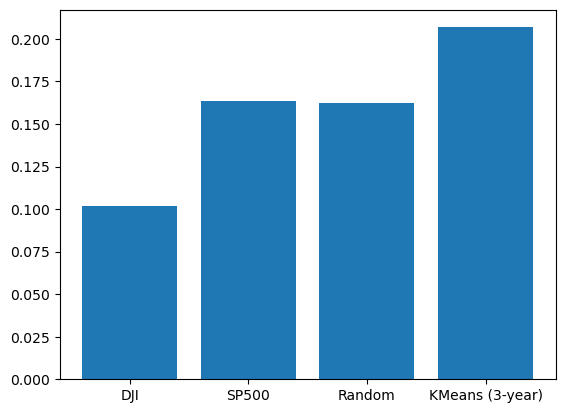

In [22]:
dates = pd.to_datetime(kmeans3s_returns.index)
eoy =  dates.to_series().groupby(dates.year).max().astype(str).tolist()
display(kmeans3s_returns.loc[eoy][['DJI', 'SP500', 'Random', 'KMeans (3-year)']])
print(kmeans3s_returns.loc[eoy][['DJI', 'SP500', 'Random', 'KMeans (3-year)']].mean())
plt.bar(['DJI', 'SP500', 'Random', 'KMeans (3-year)'], kmeans3s_returns.loc[eoy][['DJI', 'SP500', 'Random', 'KMeans (3-year)']].mean());

,DJI,SP500,Random,KMeans (3-year)
Sell Date,,,,
2017-12-27,0.206079,0.207164,0.160404,0.168485
2018-12-27,-0.024096,-0.024044,-0.019718,-0.042005
2019-12-31,0.101954,0.158970,0.142023,0.148841
2020-12-31,0.011851,0.031743,0.029500,0.063330
2021-12-30,0.090948,0.120223,0.107729,0.098575
2022-12-29,-0.029849,-0.041302,-0.038702,-0.047915
2023-12-27,0.068684,0.094707,0.081574,0.073078


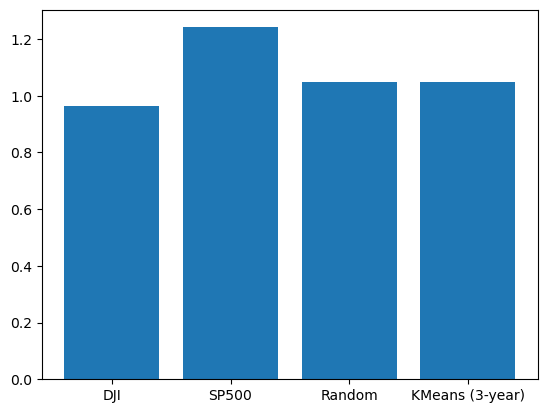

In [8]:
kmeans3s_sharpe = kmeans3s[['Sell', 'DJI_Sharpe', 'SP500_Sharpe', 'Random_Sharpe', 'sharpe']]
kmeans3s_sharpe.columns = ['Sell Date', 'DJI', 'SP500', 'Random', 'KMeans (3-year)']
kmeans3s_sharpe = kmeans3s_sharpe.set_index('Sell Date')
dates = pd.to_datetime(kmeans3s_sharpe.index)
eoy =  dates.to_series().groupby(dates.year).max().astype(str).tolist()
display(kmeans3s_sharpe.loc[eoy])
plt.bar(kmeans3s_sharpe.columns, kmeans3s_sharpe.loc[eoy].mean() * np.sqrt(252));

,DJI,SP500,Random,KMeans (3-year)
Sell Date,,,,
2017-12-27,0.302871,0.297326,0.246072,0.238345
2018-12-27,-0.029759,-0.030011,-0.025677,-0.052692
2019-12-31,0.123697,0.203784,0.189172,0.196946
2020-12-31,0.013089,0.033816,0.032562,0.069176
2021-12-30,0.125321,0.165878,0.156961,0.133762
2022-12-29,-0.045496,-0.067744,-0.062904,-0.073511
2023-12-27,0.111685,0.149568,0.132275,0.109241


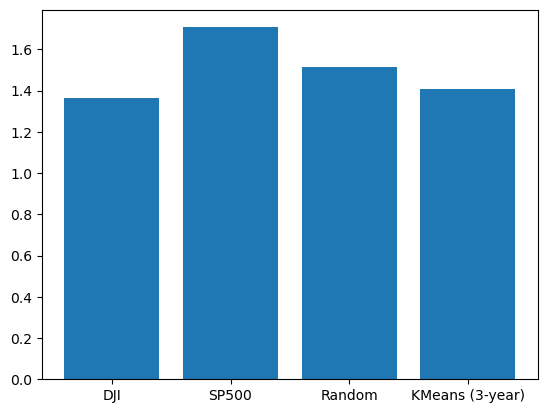

In [9]:
kmeans3s_sortino = kmeans3s[['Sell', 'DJI_Sortino', 'SP500_Sortino', 'Random_Sortino', 'sortino']]
kmeans3s_sortino.columns = ['Sell Date', 'DJI', 'SP500', 'Random', 'KMeans (3-year)']
kmeans3s_sortino = kmeans3s_sortino.set_index('Sell Date')
dates = pd.to_datetime(kmeans3s_sortino.index)
eoy =  dates.to_series().groupby(dates.year).max().astype(str).tolist()
display(kmeans3s_sortino.loc[eoy])
plt.bar(kmeans3s_sortino.columns, kmeans3s_sortino.loc[eoy].mean() * np.sqrt(252));

### KMeans (5:1)

In [10]:
kmeans5s = pd.read_csv('data/kmedoids_scaled_5-1.csv')
kmeans5s['rank'] = kmeans5s.groupby('Sell')['sharpe'].rank(method='max', ascending=False)
kmeans5s = kmeans5s[kmeans5s['rank'] == 1].drop(['rank'], axis = 1)

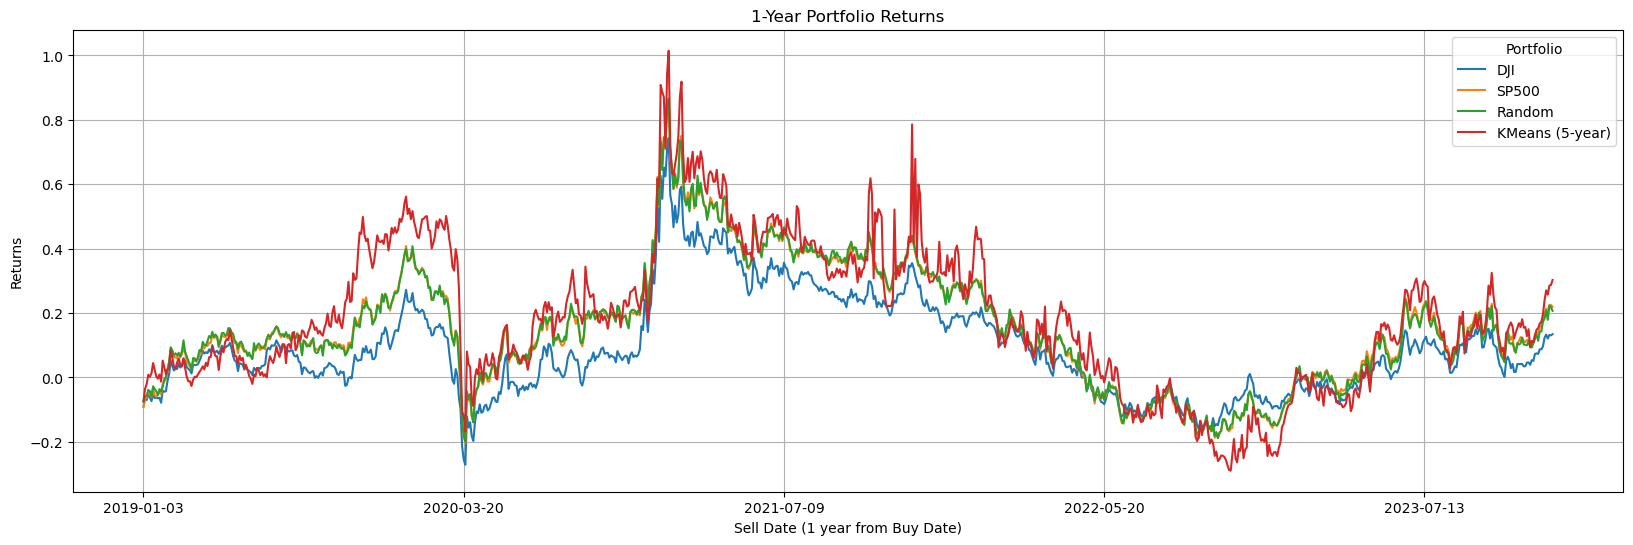

In [11]:
kmeans5s_returns = kmeans5s[['Sell', 'DJI_Return', 'SP500_Return', 'Random_Return', 'return']]
kmeans5s_returns.columns = ['Sell Date', 'DJI', 'SP500', 'Random', 'KMeans (5-year)']
kmeans5s_returns = kmeans5s_returns.set_index('Sell Date')
ig, ax = plt.subplots(figsize=(20, 6))

kmeans5s_returns.plot(ax=ax)

ax.set_title('1-Year Portfolio Returns')
ax.set_xlabel('Sell Date (1 year from Buy Date)')
ax.set_ylabel('Returns')
ax.legend(title='Portfolio')
ax.grid(True)

# Show the plot
plt.show()



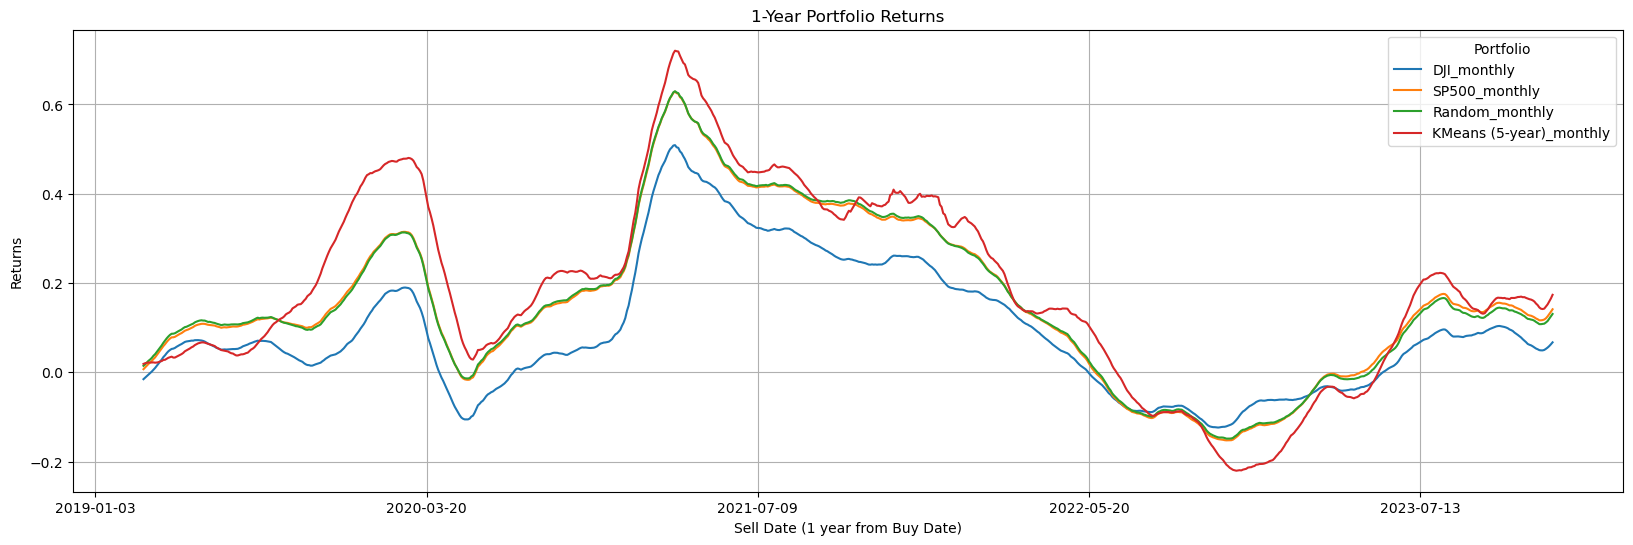

In [12]:
cols = ['DJI', 'SP500', 'Random', 'KMeans (5-year)']
cols_monthly = []
for k in cols:
    colname = f"{k}_monthly"
    kmeans5s_returns[colname] = kmeans5s_returns[k].rolling(window=30).mean()
    cols_monthly.append(colname)

fig, ax = plt.subplots(figsize=(20, 6))


kmeans5s_returns[cols_monthly].plot(ax=ax)

ax.set_title('1-Year Portfolio Returns')
ax.set_xlabel('Sell Date (1 year from Buy Date)')
ax.set_ylabel('Returns')
ax.legend(title='Portfolio')
ax.grid(True)

# Show the plot
plt.show()

,DJI,SP500,Random,KMeans (5-year)
Sell Date,,,,
2019-12-30,0.234136,0.368342,0.363398,0.524152
2020-12-28,0.062281,0.186437,0.185177,0.196971
2021-12-31,0.187275,0.288420,0.278877,0.431235
2022-12-30,-0.089313,-0.148165,-0.146392,-0.231379
2023-12-29,0.134516,0.219223,0.206748,0.302693


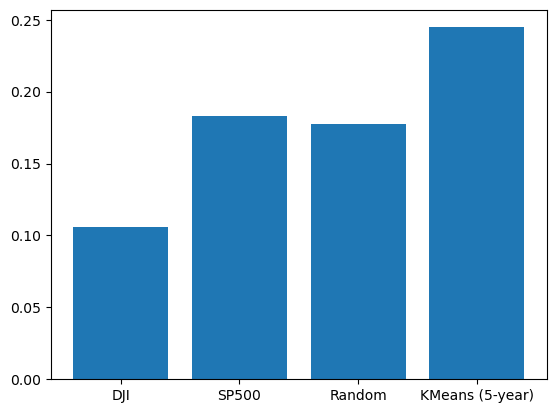

In [13]:
dates = pd.to_datetime(kmeans5s_returns.index)
eoy =  dates.to_series().groupby(dates.year).max().astype(str).tolist()
display(kmeans5s_returns.loc[eoy][['DJI', 'SP500', 'Random', 'KMeans (5-year)']])
plt.bar(['DJI', 'SP500', 'Random', 'KMeans (5-year)'], kmeans5s_returns.loc[eoy][['DJI', 'SP500', 'Random', 'KMeans (5-year)']].mean());

,DJI,SP500,Random,KMeans (5-year)
Sell Date,,,,
2019-12-30,0.106005,0.162305,0.140583,0.150423
2020-12-28,0.010235,0.030013,0.028915,0.024600
2021-12-31,0.086928,0.117038,0.103209,0.119790
2022-12-30,-0.029764,-0.041853,-0.038713,-0.053079
2023-12-29,0.070132,0.092691,0.078217,0.099145


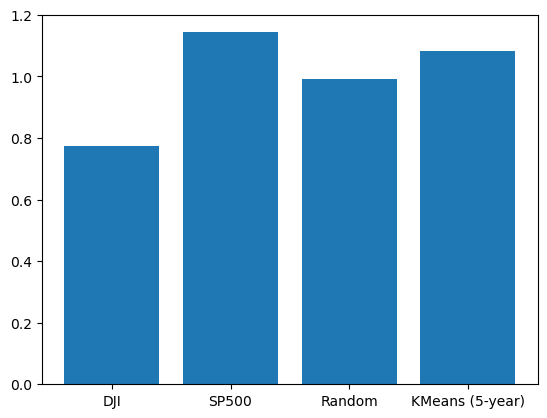

In [14]:
kmeans5s_sharpe = kmeans5s[['Sell', 'DJI_Sharpe', 'SP500_Sharpe', 'Random_Sharpe', 'sharpe']]
kmeans5s_sharpe.columns = ['Sell Date', 'DJI', 'SP500', 'Random', 'KMeans (5-year)']
kmeans5s_sharpe = kmeans5s_sharpe.set_index('Sell Date')
dates = pd.to_datetime(kmeans5s_sharpe.index)
eoy =  dates.to_series().groupby(dates.year).max().astype(str).tolist()
display(kmeans5s_sharpe.loc[eoy])
plt.bar(kmeans5s_sharpe.columns, kmeans5s_sharpe.loc[eoy].mean() * np.sqrt(252));

,DJI,SP500,Random,KMeans (5-year)
Sell Date,,,,
2019-12-30,0.129066,0.208522,0.186352,0.233499
2020-12-28,0.011315,0.031975,0.032062,0.028020
2021-12-31,0.119913,0.161321,0.150364,0.167494
2022-12-30,-0.045356,-0.068767,-0.062744,-0.086064
2023-12-29,0.113058,0.145020,0.124768,0.146908


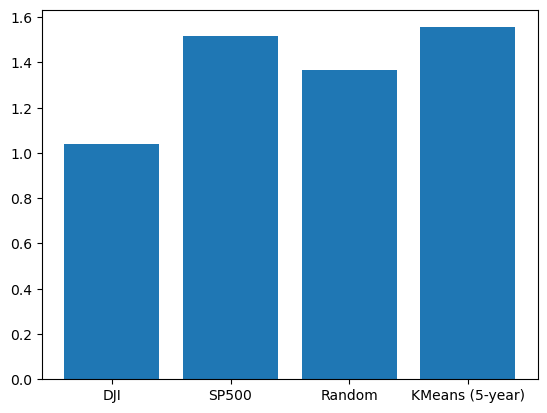

In [15]:
kmeans5s_sortino = kmeans5s[['Sell', 'DJI_Sortino', 'SP500_Sortino', 'Random_Sortino', 'sortino']]
kmeans5s_sortino.columns = ['Sell Date', 'DJI', 'SP500', 'Random', 'KMeans (5-year)']
kmeans5s_sortino = kmeans5s_sortino.set_index('Sell Date')
dates = pd.to_datetime(kmeans5s_sortino.index)
eoy =  dates.to_series().groupby(dates.year).max().astype(str).tolist()
display(kmeans5s_sortino.loc[eoy])
plt.bar(kmeans5s_sortino.columns, kmeans5s_sortino.loc[eoy].mean() * np.sqrt(252));

### KMeans (7:1)

In [16]:
kmeans7s = pd.read_csv('data/kmedoids_scaled_7-1.csv')
kmeans7s['rank'] = kmeans7s.groupby('Sell')['sharpe'].rank(method='max', ascending=False)
kmeans7s = kmeans7s[kmeans7s['rank'] == 1].drop(['rank'], axis = 1)

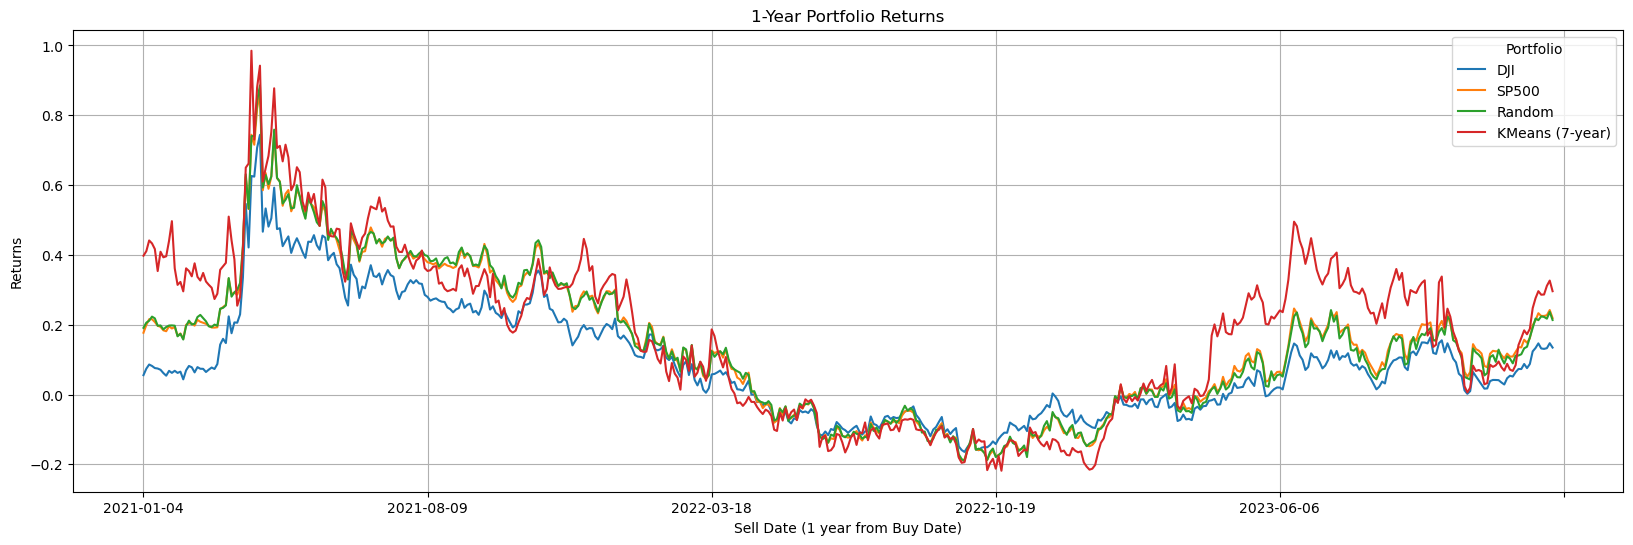

In [17]:
kmeans7s_returns = kmeans7s[['Sell', 'DJI_Return', 'SP500_Return', 'Random_Return', 'return']]
kmeans7s_returns.columns = ['Sell Date', 'DJI', 'SP500', 'Random', 'KMeans (7-year)']
kmeans7s_returns = kmeans7s_returns.set_index('Sell Date')
ig, ax = plt.subplots(figsize=(20, 6))

kmeans7s_returns.plot(ax=ax)

ax.set_title('1-Year Portfolio Returns')
ax.set_xlabel('Sell Date (1 year from Buy Date)')
ax.set_ylabel('Returns')
ax.legend(title='Portfolio')
ax.grid(True)

# Show the plot
plt.show()

,DJI,SP500,Random,KMeans (7-year)
Sell Date,,,,
2021-12-31,0.187275,0.288420,0.289460,0.345311
2022-12-30,-0.089313,-0.148165,-0.140454,-0.215253
2023-12-29,0.134516,0.219223,0.213526,0.296018


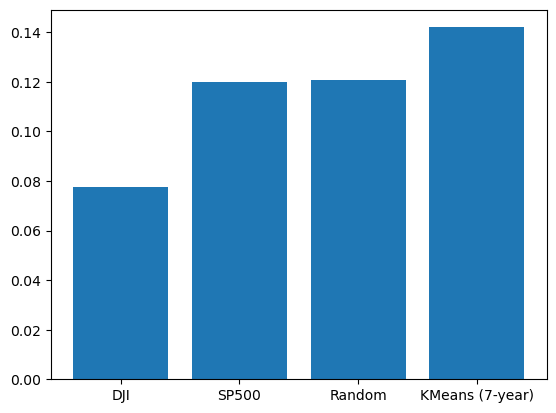

In [18]:
dates = pd.to_datetime(kmeans7s_returns.index)
eoy =  dates.to_series().groupby(dates.year).max().astype(str).tolist()
display(kmeans7s_returns.loc[eoy][['DJI', 'SP500', 'Random', 'KMeans (7-year)']])
plt.bar(['DJI', 'SP500', 'Random', 'KMeans (7-year)'], kmeans7s_returns.loc[eoy][['DJI', 'SP500', 'Random', 'KMeans (7-year)']].mean());

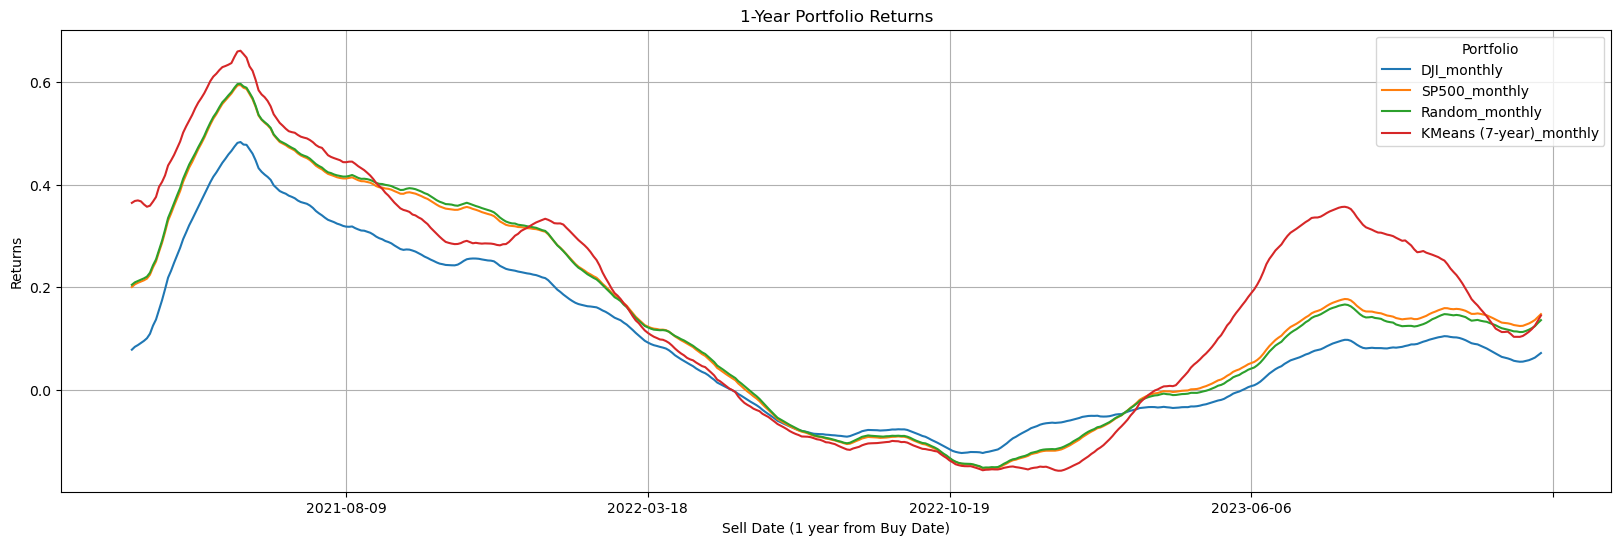

In [19]:
cols = ['DJI', 'SP500', 'Random', 'KMeans (7-year)']
cols_monthly = []
for k in cols:
    colname = f"{k}_monthly"
    kmeans7s_returns[colname] = kmeans7s_returns[k].rolling(window=30).mean()
    cols_monthly.append(colname)

fig, ax = plt.subplots(figsize=(20, 6))


kmeans7s_returns[cols_monthly].plot(ax=ax)

ax.set_title('1-Year Portfolio Returns')
ax.set_xlabel('Sell Date (1 year from Buy Date)')
ax.set_ylabel('Returns')
ax.legend(title='Portfolio')
ax.grid(True)

# Show the plot
plt.show()

,DJI,SP500,Random,KMeans (7-year)
Sell Date,,,,
2021-12-31,0.086928,0.117038,0.105634,0.101504
2022-12-30,-0.029764,-0.041853,-0.038480,-0.050116
2023-12-29,0.070132,0.092691,0.081106,0.092800


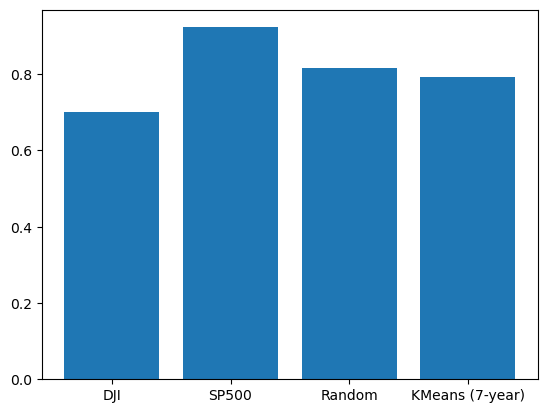

In [20]:
kmeans7s_sharpe = kmeans7s[['Sell', 'DJI_Sharpe', 'SP500_Sharpe', 'Random_Sharpe', 'sharpe']]
kmeans7s_sharpe.columns = ['Sell Date', 'DJI', 'SP500', 'Random', 'KMeans (7-year)']
kmeans7s_sharpe = kmeans7s_sharpe.set_index('Sell Date')
dates = pd.to_datetime(kmeans7s_sharpe.index)
eoy =  dates.to_series().groupby(dates.year).max().astype(str).tolist()
display(kmeans7s_sharpe.loc[eoy])
plt.bar(kmeans7s_sharpe.columns, kmeans7s_sharpe.loc[eoy].mean() * np.sqrt(272));

,DJI,SP500,Random,KMeans (7-year)
Sell Date,,,,
2021-12-31,0.119913,0.161321,0.153342,0.139393
2022-12-30,-0.045356,-0.068767,-0.062072,-0.081322
2023-12-29,0.113058,0.145020,0.129627,0.143660


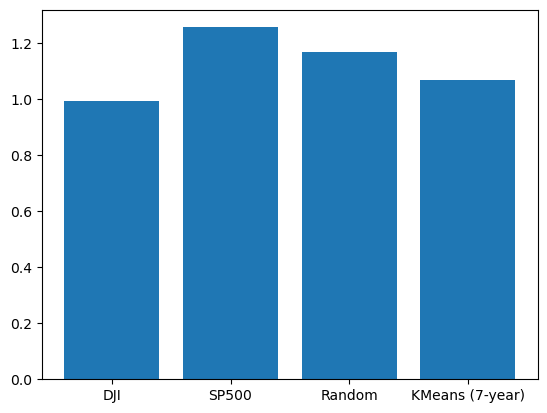

In [21]:
kmeans7s_sortino = kmeans7s[['Sell', 'DJI_Sortino', 'SP500_Sortino', 'Random_Sortino', 'sortino']]
kmeans7s_sortino.columns = ['Sell Date', 'DJI', 'SP500', 'Random', 'KMeans (7-year)']
kmeans7s_sortino = kmeans7s_sortino.set_index('Sell Date')
dates = pd.to_datetime(kmeans7s_sortino.index)
eoy =  dates.to_series().groupby(dates.year).max().astype(str).tolist()
display(kmeans7s_sortino.loc[eoy])
plt.bar(kmeans7s_sortino.columns, kmeans7s_sortino.loc[eoy].mean() * np.sqrt(252));